# Spectra

Model [Cree emitters](https://assets.cree-led.com/a/ds/x/XLamp-XPE2.pdf) and Roscolux filters and a few other spectral functions.

In [1]:
import scipy.constants
import matplotlib.pyplot as plt
import cupy as cp

import spectra
import optics_cuda


/home/joel/.local/lib/python3.8/site-packages/cupyx/jit/_interface.py:161: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')
/home/joel/.local/lib/python3.8/site-packages/cupyx/jit/_interface.py:161: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


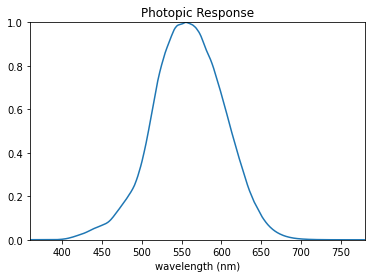

In [8]:
# this is the luminous efficiency function: wikipedia.org/wiki/Luminous_efficiency_function

spectra.Photopic.PHOTOPIC.plot()

From [Wikipedia](https://en.wikipedia.org/wiki/Luminous_efficiency_function), to compute luminous flux:

$$
\Phi_v (lm) = 683\, \cdot \int_{0}^{\infty} \bar{y}(\lambda)(lm/W)\Phi_{e,\lambda}(\lambda)(W/nm) \,d\lambda (nm)
$$

where

* $\Phi_v$ is luminous flux (lm)
* $\Phi_{e,\lambda}$ is spectral radiant flux (W/nm)
* $\bar{y}(\lambda)$ is the luminous efficiency function (lm/W), normalized to 1
* $\lambda$ is wavelength (nm)

For simulation we keep track of individual photons, so do this instead:

$$
\Phi_v = 683 (lm/W) \cdot \sum \bar{y}(\lambda)E \Delta t
$$

for each photon energy, E, in Joules, and $\Delta t$ in seconds.

Equivalently:

$$
\Phi_v = 683 (lm/W) \cdot \sum \bar{y}(\lambda)\frac{hc}{\lambda} \Delta t
$$

for each photon wavelength, $\lambda$.

For ease of calculation, the function $\bar{y}$ can be replaced:

$$
\bar{y}^{\prime} = 683 \bar{y}(\lambda) \frac{hc}{\lambda}
$$

[360.  360.1 360.2 ... 779.7 779.8 779.9]
[4.130e-04 4.130e-04 4.130e-04 ... 1.427e-05 1.418e-05 1.409e-05]


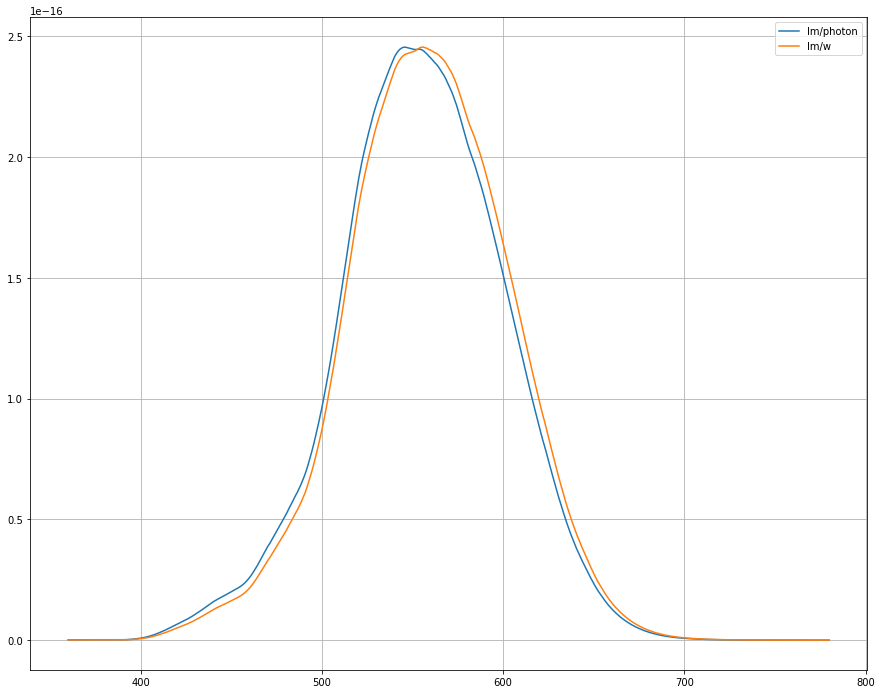

In [9]:
(pdf_x, pdf_y) = spectra.Photopic.PHOTOPIC.pdf()
print(pdf_x) # nm
print(pdf_y) # normalized to 1

wavelength_m = pdf_x * 1e-9
frequency_hz = scipy.constants.c / wavelength_m
energy_per_photon_j = scipy.constants.h * frequency_hz

lumen_seconds_per_joule_per_nm = pdf_y * 683

lumen_seconds_per_photon_per_nm = lumen_seconds_per_joule_per_nm * energy_per_photon_j

f = plt.figure(figsize=[15,12])
plt.plot(pdf_x.get(), lumen_seconds_per_photon_per_nm.get(), label='lm/photon')
plt.plot(pdf_x.get(), (pdf_y*2.455057894116347e-16).get(), label='lm/w')
plt.grid(True)
plt.legend()
plt.show()
#print(max(lumen_seconds_per_photon_per_nm.get()))
# so since the watts per photon is higher for blue photons the luminous
# efficiency on the blue end is a little higher.

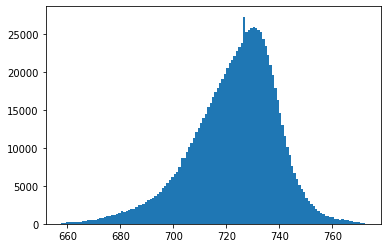

In [10]:
# using this to generate photons is wrong, it describes spectral __power__ (w/nm)
size = 1000000
spectral_flux = spectra.SourceSpectrum.LED_FAR_RED.emit(size)
plt.hist(spectral_flux.get(), bins=127)
plt.show()

[5.51790516e-19 5.51637283e-19 5.51484136e-19 ... 2.54770534e-19
 2.54737863e-19 2.54705200e-19]


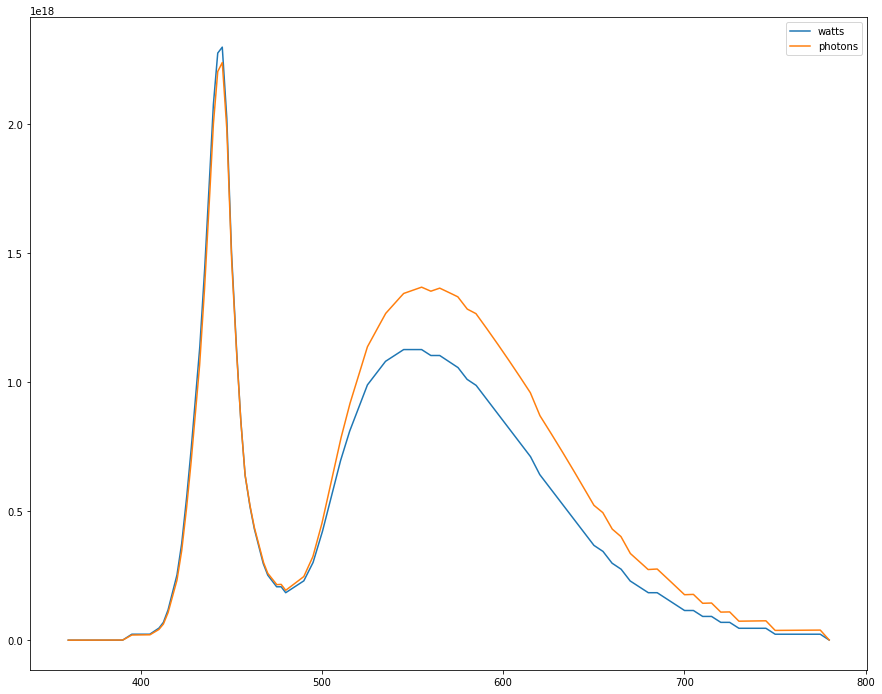

In [2]:
# to generate photons, we need to correct for the energy of each photon:
# w/nm * photons/w
f = plt.figure(figsize=[15,12])
size = 1000000
spectral_flux = spectra.SourceSpectrum.LED_COOL_WHITE.emit(size)
h,b = cp.histogram(spectral_flux, bins=127)
#plt.plot(((b[1:]+b[:-1])/2).get(), h.get(), label = 'spectral flux')

nm = spectra.SourceSpectrum.LED_COOL_WHITE._x
spectral_flux_j_s_nm = spectra.SourceSpectrum.LED_COOL_WHITE._y

wavelength_m = nm * 1e-9
frequency_hz = scipy.constants.c / wavelength_m
energy_per_photon_j = scipy.constants.h * frequency_hz
print(energy_per_photon_j)
spectral_photon_flux_photons_s_nm = spectral_flux_j_s_nm / energy_per_photon_j

plt.plot(nm.get(), (2.3e18*spectra.SourceSpectrum.LED_COOL_WHITE._y).get(), label='watts')
plt.plot(nm.get(), spectral_photon_flux_photons_s_nm.get(), label='photons')
# same!
#plt.plot(nm.get(), spectra.SourceSpectrum.LED_COOL_WHITE._spectral_photon_flux_photons_s_nm.get(), label='photons')

plt.legend()


photon_flux = spectra.Emitter.generate_rand_from_pdf(spectral_photon_flux_photons_s_nm, nm, size)
#plt.hist(photon_flux.get(), bins=100)
#plt.show()
# compare
h,b = cp.histogram(photon_flux, bins=127)
#plt.plot(((b[1:]+b[:-1])/2).get(), h.get(), label = 'photon flux')
plt.show()


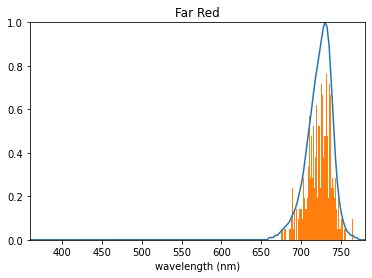

In [12]:
spectra.SourceSpectrum.LED_FAR_RED.plot()

In [2]:

size = 800000 # 160 * 5000000 = 800000000 in BackgroundSimulator, so this is 1/1000th.
photons_per_bundle = 3e4 # same as BackgroundSimulator
duration_s = 0.001 # same as BackgroundSimulator
# green is around 525nm, so each photon is 3.78e-19 joules.
green_photon_wavelength_nm = spectra.SourceSpectrum.LED_GREEN.emit(size)
green_alive = cp.ones(size)
energy_j = optics_cuda.Photons.energy_j_kernel(green_photon_wavelength_nm, photons_per_bundle, green_alive)
power_w = energy_j / duration_s

print(f"green photons {(size * photons_per_bundle):.3e}")
print(f"green power {power_w:.3e} W") # 9 uW

# so since 525nm is close to the peak photopic, 638 lm/w so 9e-6*638 = about 6e-3 lm.

#idx = cp.searchsorted(spectra.Photopic.PHOTOPIC._x, green_photon_wavelength_nm)
#lumen_seconds_per_photon = spectra.Photopic.PHOTOPIC._lumen_seconds_per_photon_per_nm[idx]
#lumen_seconds = cp.sum(lumen_seconds_per_photon) * photons_per_bundle
lumen_seconds = spectra.Photopic.PHOTOPIC.lumen_seconds(green_photon_wavelength_nm,
                                                        photons_per_bundle, green_alive)
lumens = lumen_seconds/duration_s
print(f"green luminous flux {lumens:.3e} lm")

# the camera is kind of like a filter.
# the camera is very sensitive to green, producing almost as many electrons as there are incident
# photons
spectra.CameraSpectrum.CAMERA_SEE_3_CAM.absorb(green_photon_wavelength_nm, green_alive)
electrons_produced = cp.sum(green_alive) * photons_per_bundle
print(f"green electrons in camera {electrons_produced:.3e}")

# for white, for the same photon flux, there is less power and less luminous flux.
cool_white_photon_wavelength_nm = spectra.SourceSpectrum.LED_COOL_WHITE.emit(size)
white_alive = cp.ones(size)

energy_j = optics_cuda.Photons.energy_j_kernel(cool_white_photon_wavelength_nm,
                                               photons_per_bundle, white_alive)
power_w = energy_j / duration_s
print(f"cool white photons {(size * photons_per_bundle):.3e}")
print(f"cool white power {power_w:.3e} W") # 9 uW

idx = cp.searchsorted(spectra.Photopic.PHOTOPIC._x, cool_white_photon_wavelength_nm)
lumen_seconds_per_photon = spectra.Photopic.PHOTOPIC._lumen_seconds_per_photon_per_nm[idx]
lumen_seconds = cp.sum(lumen_seconds_per_photon) * photons_per_bundle
lumens = lumen_seconds/duration_s
print(f"cool white luminous flux {lumens:.3e} lm")

# the camera is kind of like a filter
# something like 20% of the white spectrum is in the blue peak around 450nm, and the camera
# can only see ~70% of that, so this should be down ~6% from the green case
spectra.CameraSpectrum.CAMERA_SEE_3_CAM.absorb(cool_white_photon_wavelength_nm, white_alive)
electrons_produced = cp.sum(white_alive) * photons_per_bundle
print(f"cool white electrons in camera {electrons_produced:.3e}")



green photons 2.400e+10
green power 9.016e-06 W
green luminous flux 4.704e-03 lm
green electrons in camera 2.340e+10
cool white photons 2.400e+10
cool white power 8.821e-06 W
cool white luminous flux 2.938e-03 lm
cool white electrons in camera 2.215e+10


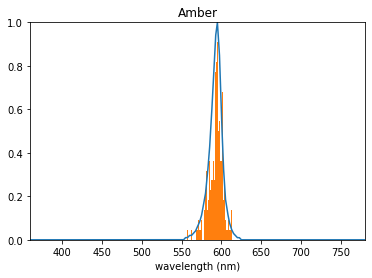

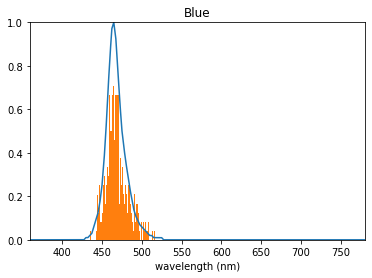

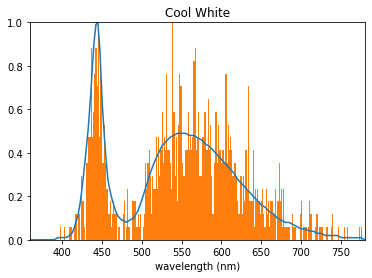

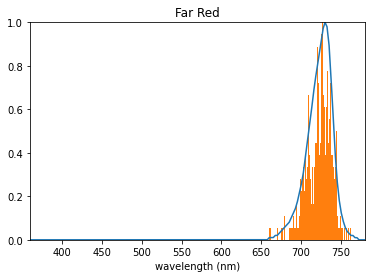

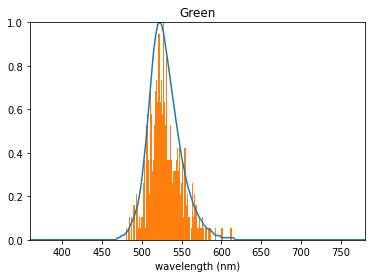

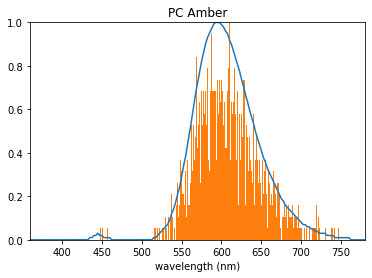

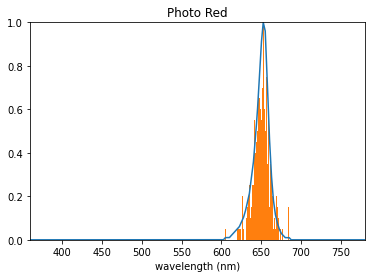

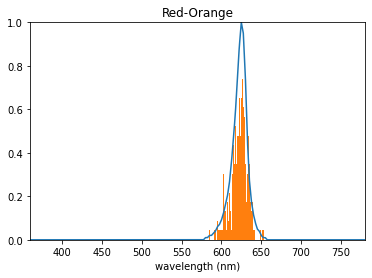

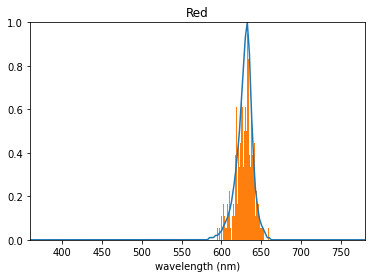

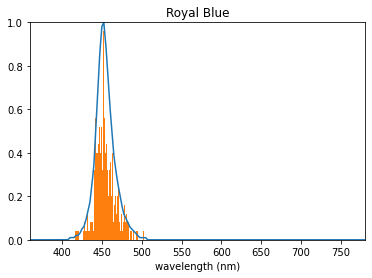

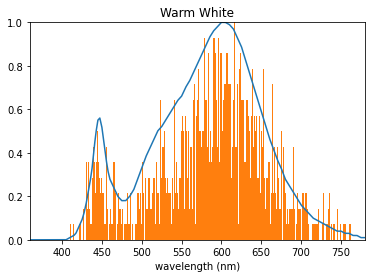

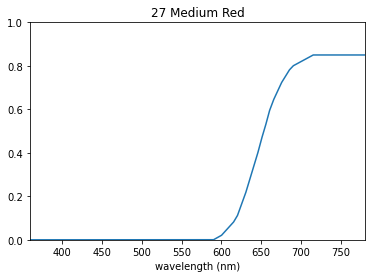

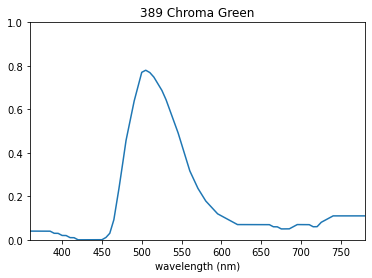

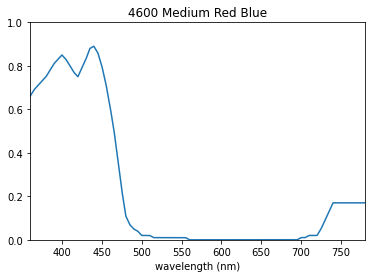

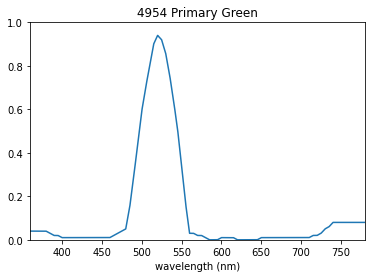

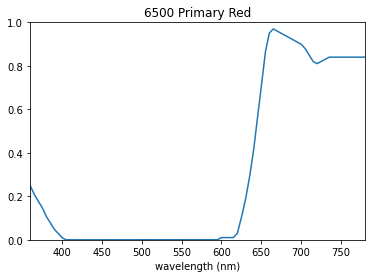

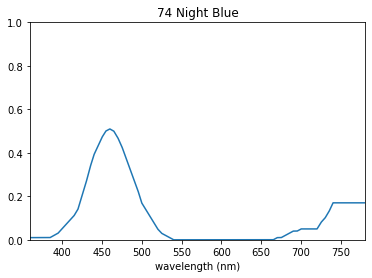

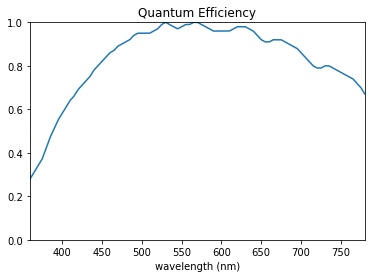

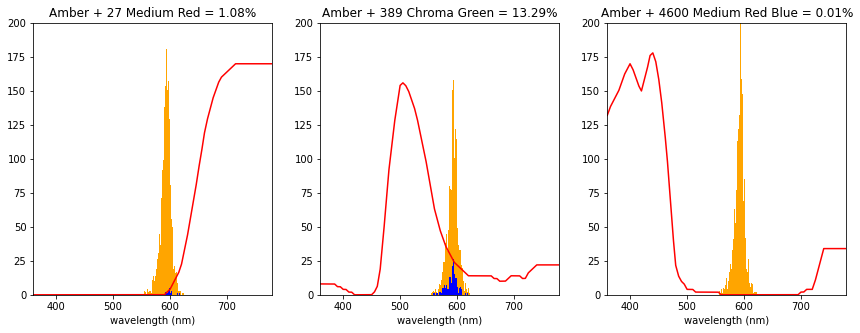

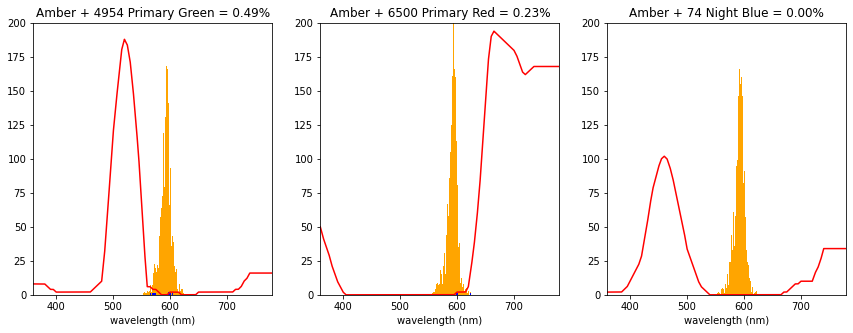

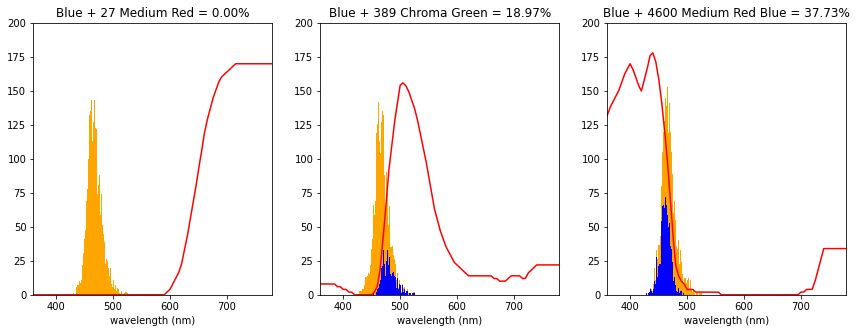

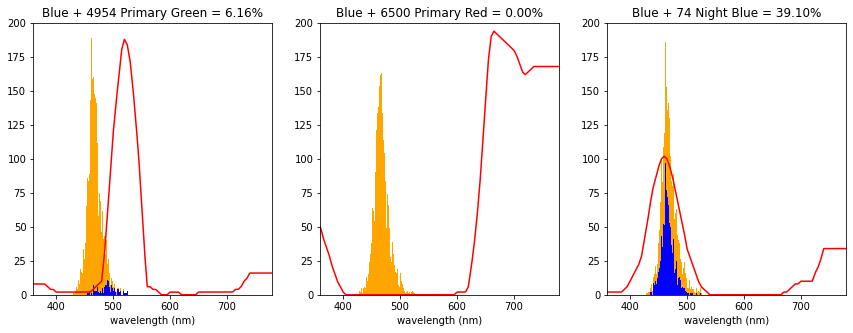

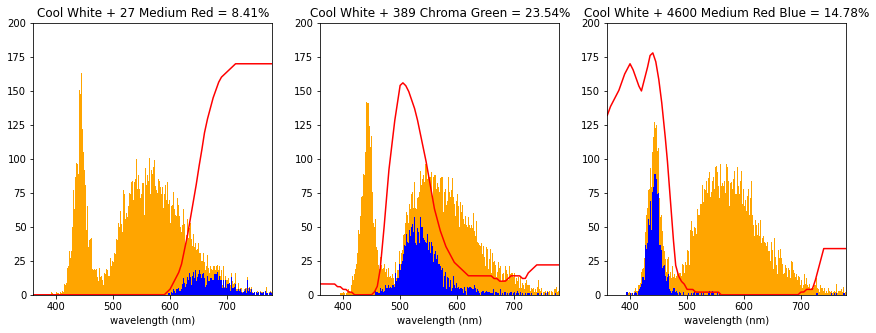

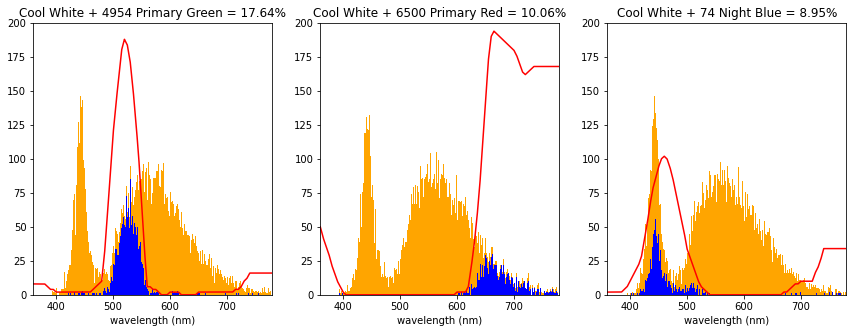

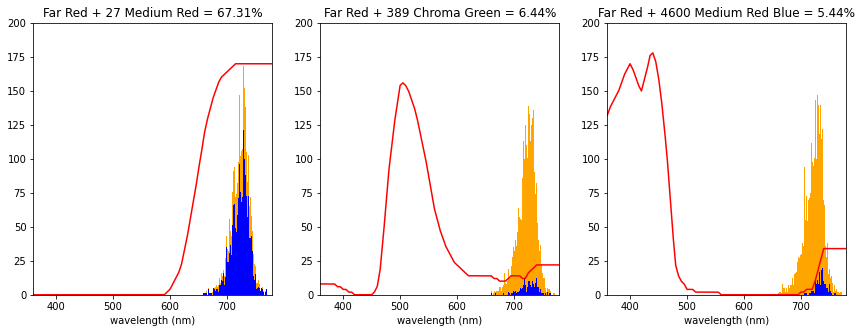

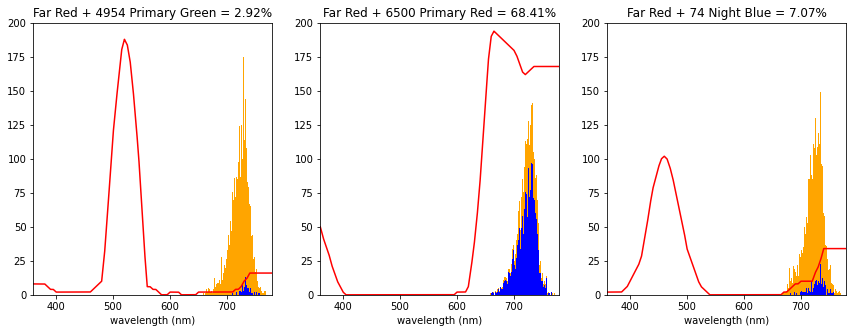

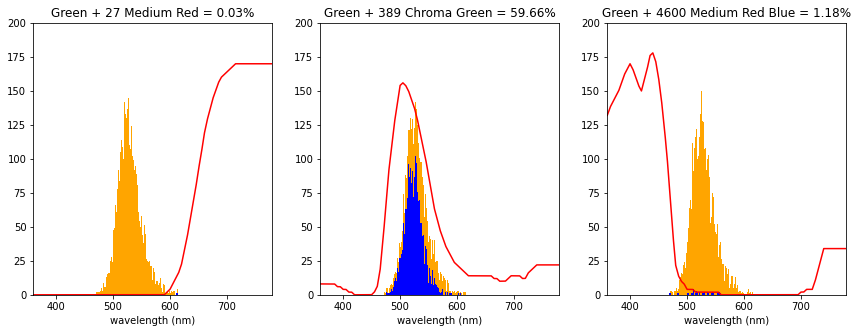

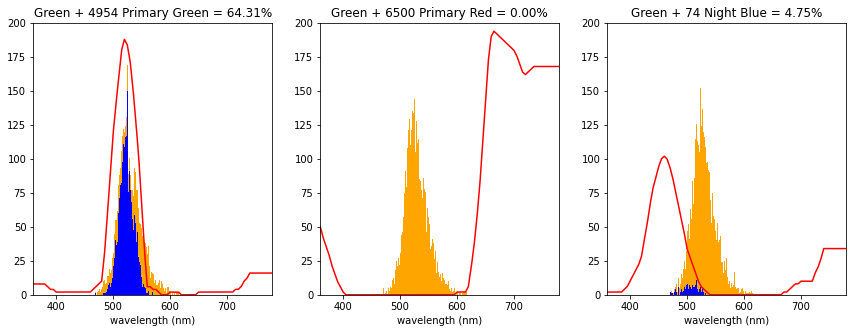

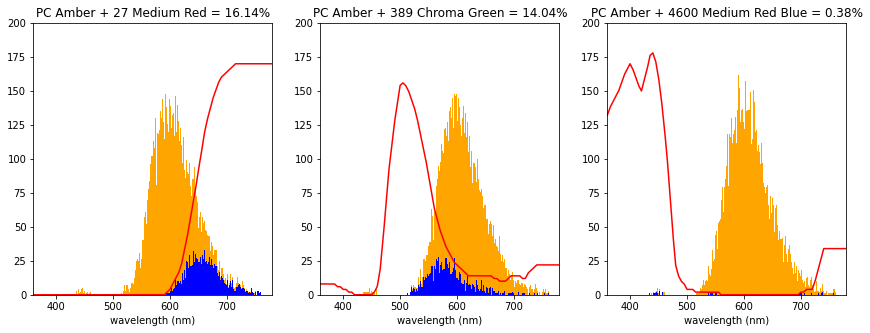

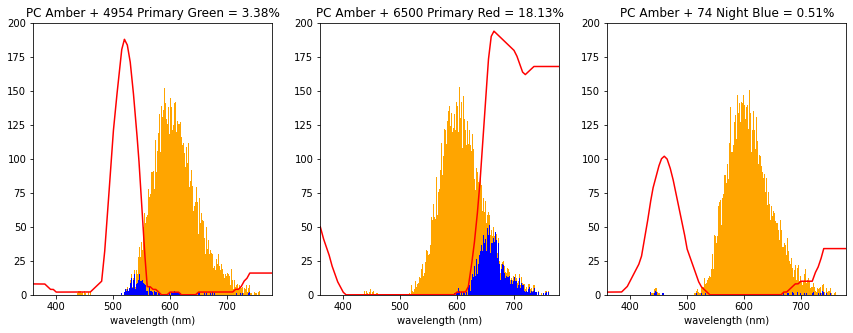

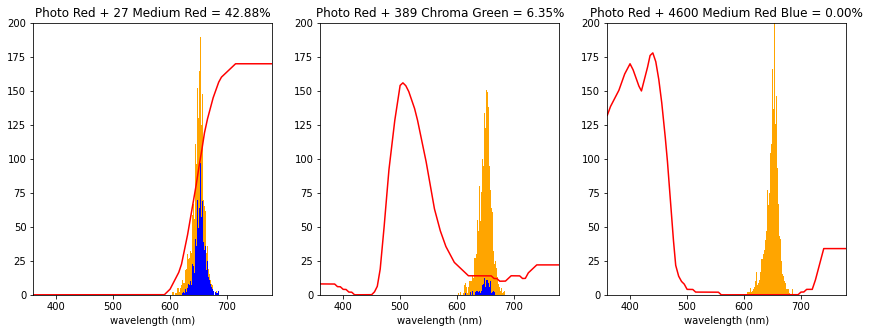

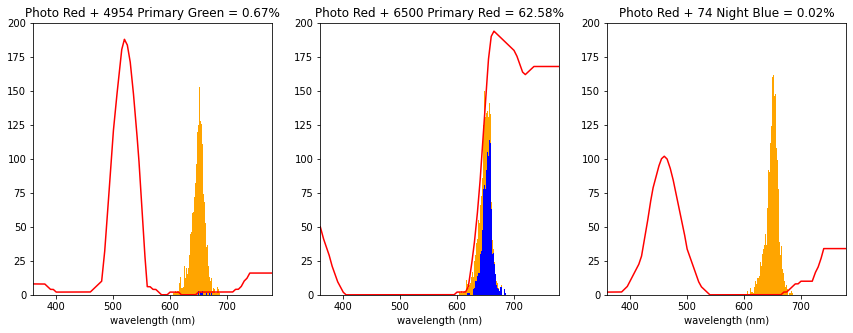

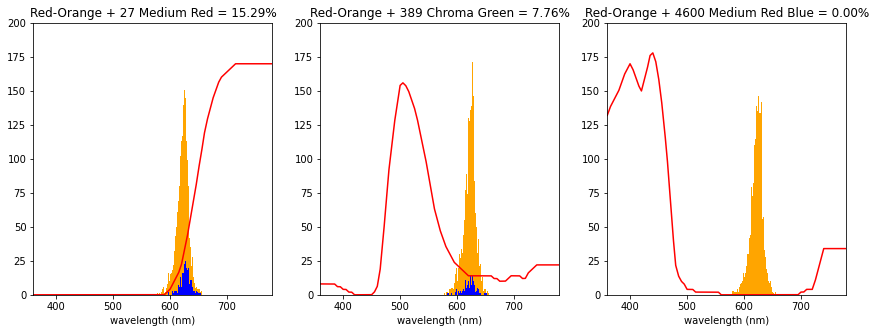

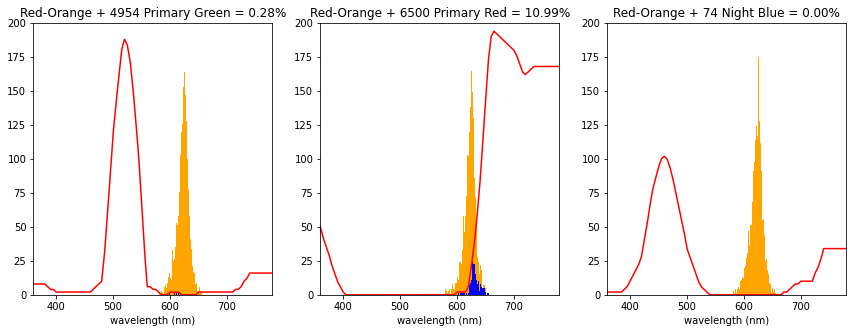

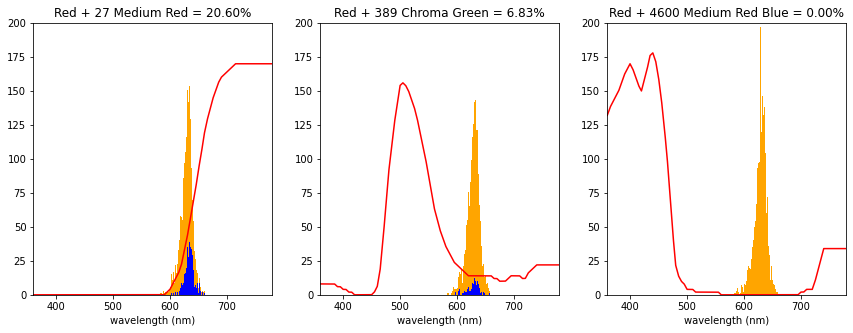

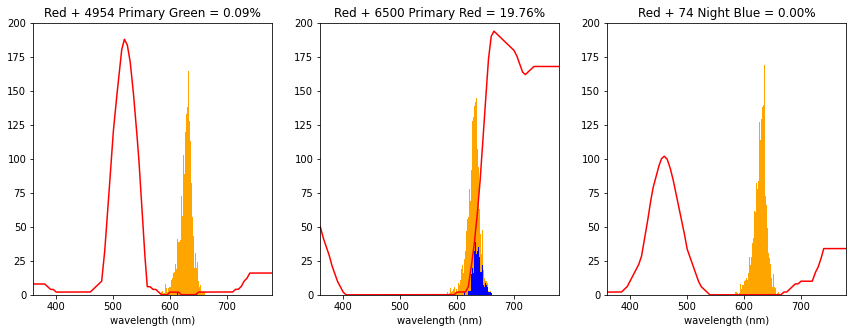

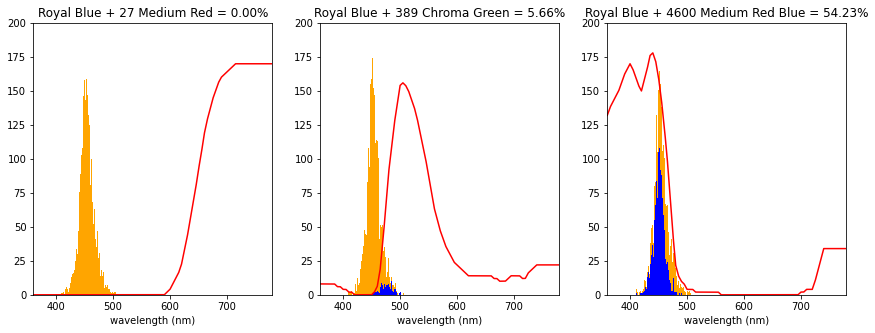

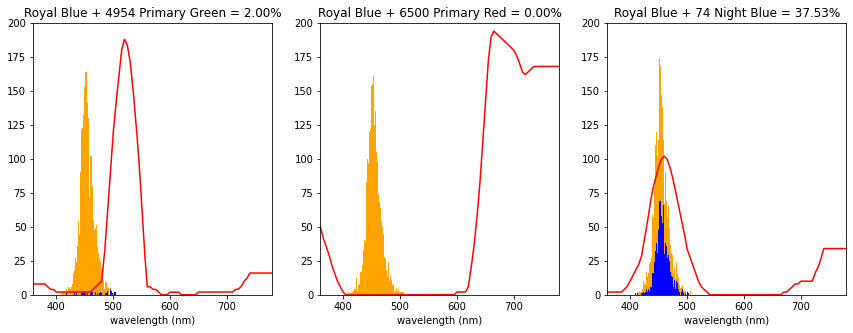

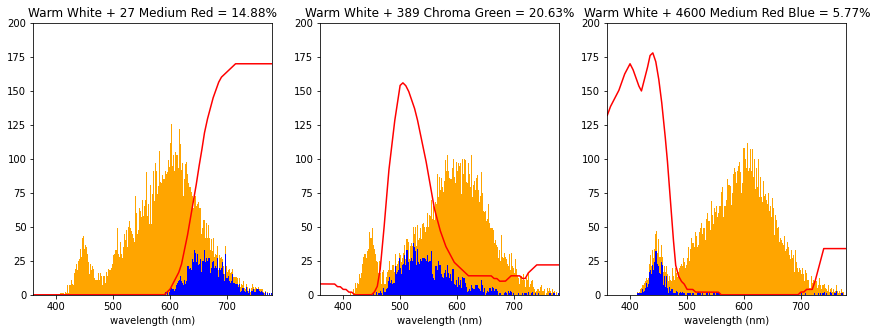

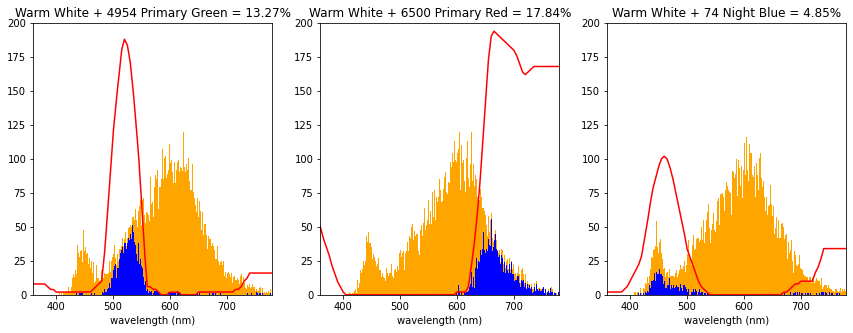

In [7]:
for spec in spectra.SourceSpectrum:
    spec.plot()

for spec in spectra.FilterSpectrum:
    spec.plot()

for spec in spectra.CameraSpectrum:
    spec.plot()
        
spectra.compare_all()